### Set-up

In [2]:
from collections import defaultdict

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
from ema_workbench import load_results, save_results, TimeSeriesOutcome
from ema_workbench.analysis import clusterer

In [5]:
path = '../results/'
file_name = '2000_scen__40_reps__0612'
file_ext  = '.tar.gz'

In [6]:
experiments, outcomes = load_results(path+file_name+file_ext)

In [7]:
# experiments, outcomes = load_results('../results/stochasticity_test_0607.tar.gz')

In [8]:
oois = ['Household Population', 'GDP', 'Gini Coefficient']

## Calculating Across-Seed Variance & Other Measures

Need: one or measures of how each outcome varies across seeds (i.e., replications), at a single input sample

Measures: Variance (and therefore standard deviation)? I think that's just it. I can't think of other measures of entropy. I can also calculate mean and put them together to get 95% CIs.

Later: will apply SD processes to evaluate how ASV itself varies across the input space (dim stacking, subspace partitioning, etc.). Can also apply FS to the ASV to see which inputs are important to it. 

Then finally can do the rule of thumb check.

Each key in `outcomes` is associated with a 2D array. The inner dimension contains the timeseries outcomes of a single model run (i.e., input sample x replication). The outer dimension contains the runs together.

In [25]:
print(f"Number of runs: {len(outcomes['GDP'])}")
print(f"Length of one run: {len(outcomes['GDP'][0])}")

Number of runs: 80000
Length of one run: 120


### Exploration
We want to be able to index these arrays to access all runs associated with a specific *scenario*, which should each have a different seed. Conveniently, the `experiments` DataFrame gives scenarios (i.e., input samples) an ID to help with this.

In [10]:
experiments[experiments.scenario == 0].head(3)

,debt_sales_ratio,wage_sensitivity_prod,init_markup,capital_firm_cap_out_ratio,min_unempl_emigration,migration_unempl_bounds_diff,deu_discount_factor,flood_timing,scenario,policy,model,seed
0,3.974297,0.712775,0.099379,0.297524,0.040977,0.136866,0.95654,33,0,NaN,CRAB,0
2000,3.974297,0.712775,0.099379,0.297524,0.040977,0.136866,0.95654,33,0,NaN,CRAB,1
4000,3.974297,0.712775,0.099379,0.297524,0.040977,0.136866,0.95654,33,0,NaN,CRAB,2


In [11]:
experiments[experiments.scenario == 0].index

Index([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000, 18000,
       20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000,
       40000, 42000, 44000, 46000, 48000, 50000, 52000, 54000, 56000, 58000,
       60000, 62000, 64000, 66000, 68000, 70000, 72000, 74000, 76000, 78000],
      dtype='int64')

We can use these indices to extract each scenario separately. Here's a demo:

In [28]:
print(f"GDP outcome array, subset for just Scenario 0:")
print(outcomes['GDP'][experiments[experiments.scenario == 0].index])
print("")
print(f"Number of runs in this subset (i.e., number of replications):")
print(len(outcomes['GDP'][experiments[experiments.scenario == 0].index]))

GDP outcome array, subset for just Scenario 0:
[[  900.57  11681.652 17366.517 ... 20618.418 21657.975 21303.654]
 [  900.348 11645.151 17068.44  ... 21623.649 21835.2   22355.403]
 [  902.682 11662.35  17165.904 ... 21785.508 20129.208 21769.593]
 ...
 [  901.665 11663.904 16972.449 ... 16618.161 15895.152 15643.329]
 [  899.514 11659.503 17014.236 ... 23397.24  22993.824 21261.315]
 [  902.664 11667.528 17399.811 ... 16426.605 16237.338 17568.756]]

Number of runs in this subset (i.e., number of replications):
40


### Aggregating the `outcomes` dictionary

In [13]:
scenarios = experiments.scenario.unique()
scenarios

array([   0,    1,    2, ..., 1997, 1998, 1999], dtype=int64)

In [14]:
new_outcomes = defaultdict(list)

for ooi in oois:
    for scenario in scenarios:
        # Get the N (40) timeseries outcomes of interest
        replications = outcomes[ooi][experiments[experiments.scenario == scenario].index]
        
        # Calculate variance and standard deviation
        var = np.var(replications, axis=0, ddof=1)
        std = np.std(replications, axis=0, ddof=1)
        mean = np.mean(replications, axis=0)

        # Add to datastructure
        #  new_outcomes['<metric>(Outcome)'][x], where x == scenario id,
        #   contains <metric>(Outcome) as a timeseries
        new_outcomes[f"MEAN({ooi})"].append(mean)
        new_outcomes[f"STD({ooi})"].append(std)
        new_outcomes[f"VAR({ooi})"].append(var)
        new_outcomes[f"95CI_LO({ooi})"].append(mean - 2*std)
        new_outcomes[f"95CI_HI({ooi})"].append(mean + 2*std)

In [15]:
# Turn into NP arrays
for key in new_outcomes:
    ema_outcome = TimeSeriesOutcome(key)
    new_outcomes[key] = np.array(new_outcomes[key])

In [16]:
new_outcomes['STD(Gini Coefficient)'][0][119]

0.027538570960736593

### Aggregating the `experiments` DataFrame

In [17]:
uncertainties = list(experiments.columns)
for col in ['policy', 'model', 'seed']:
    uncertainties.remove(col)
uncertainties

['debt_sales_ratio',
 'wage_sensitivity_prod',
 'init_markup',
 'capital_firm_cap_out_ratio',
 'min_unempl_emigration',
 'migration_unempl_bounds_diff',
 'deu_discount_factor',
 'flood_timing',
 'scenario']

In [18]:
new_experiments = experiments[uncertainties].groupby('scenario').agg('mean').reset_index(drop=True)
new_experiments['scenario'] = [i for i in range(len(new_experiments))]
new_experiments['policy'] = np.nan
new_experiments['model'] = 'CRAB'
new_experiments

,debt_sales_ratio,wage_sensitivity_prod,init_markup,capital_firm_cap_out_ratio,min_unempl_emigration,migration_unempl_bounds_diff,deu_discount_factor,flood_timing,scenario,policy,model
0,3.974297,0.712775,0.099379,0.297524,0.040977,0.136866,0.956540,33.0,0,NaN,CRAB
1,4.388648,0.624767,0.069494,0.246466,0.031566,0.160825,0.857878,76.0,1,NaN,CRAB
2,3.970944,0.929448,0.489306,0.339357,0.051214,0.166170,0.954534,34.0,2,NaN,CRAB
3,0.972112,0.595822,0.229186,0.399390,0.058033,0.145984,0.827532,46.0,3,NaN,CRAB
4,2.097049,0.085739,0.102101,0.530068,0.059356,0.146438,0.858569,72.0,4,NaN,CRAB
...,...,...,...,...,...,...,...,...,...,...,...
1995,3.200478,0.471664,0.139773,0.390861,0.037946,0.242404,0.825514,61.0,1995,NaN,CRAB
1996,3.591290,0.208159,0.338511,0.324545,0.050687,0.220237,0.821360,44.0,1996,NaN,CRAB
1997,4.485911,0.554342,0.224410,0.422127,0.071176,0.202716,0.821195,40.0,1997,NaN,CRAB
1998,1.809927,0.981881,0.183219,0.200401,0.037715,0.114086,0.970333,69.0,1998,NaN,CRAB


### Save results to new file

In [19]:
# Make sure new_experiments and new_outcomes' lists share the same length
num_scens = len(new_experiments)
for out in new_outcomes:
    assert(len(new_outcomes[out]) == num_scens)

In [20]:
split_file_name = file_name.split('__')
split_file_name[1] = 'AGGD_reps'
new_file_name = '__'.join(split_file_name)
path+new_file_name+file_ext

'../results/2000_scen__AGGD_reps__0612.tar.gz'

In [21]:
results = new_experiments, new_outcomes

In [22]:
save_results(results, path + new_file_name + file_ext)

c:\Users\Gabriel\Documents\Academic\EPA\2. Thesis\Code\CRAB_EM\.venv\Lib\site-packages\ema_workbench\em_framework\outcomes.py:540: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")


### Rule-of-Thumb Check for Required Number of Replications

i.e., Looking for convergence in variance as you include more replications

Take 1: Treating each scenario separately:

In [23]:
len(outcomes['GDP'])

80000

What's missing from next cell:
* Obviously, making one for all {scenario, OOI} pair instead of just the first (that's 6k graphs lol)
* Finding a cleaner way to represent the legend. Maybe as a colourbar. But I'm still struggling with hue-ification of the sns plot.
* Animation? I could save 1 graph per rep count (that's 40 graphs per {scenario, OOI} pair) and turn them into a gif? Maybe the ideal.

Putting a pin in this for now.

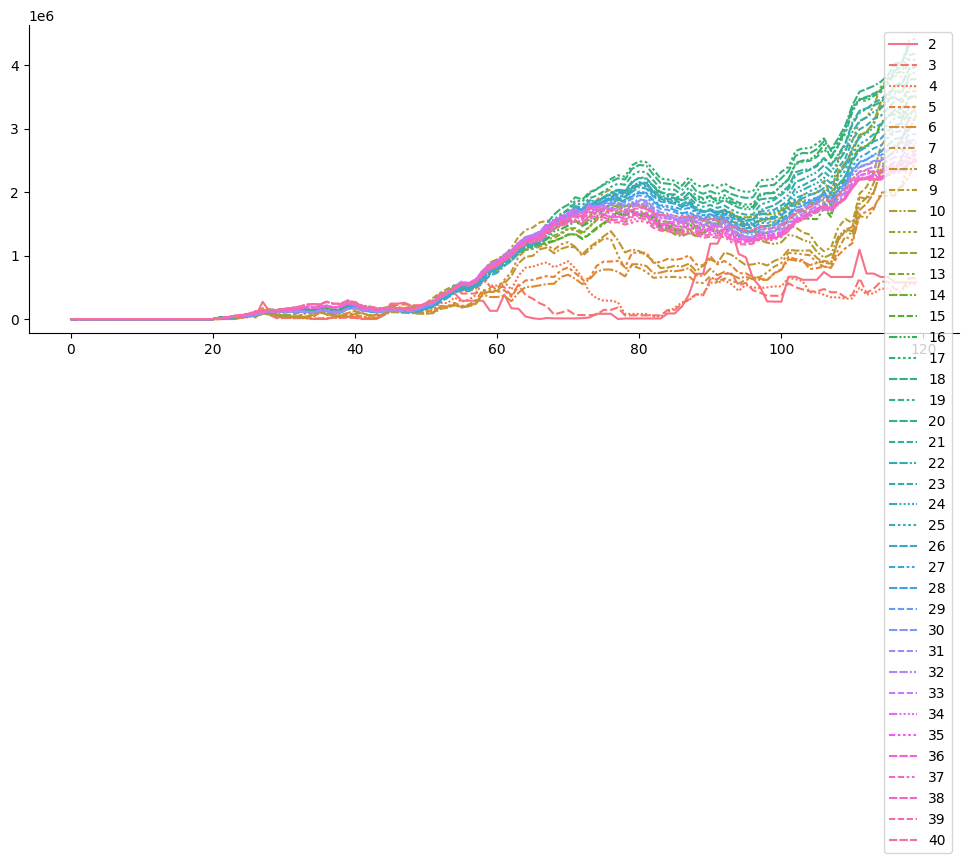

In [87]:
for ooi in oois:
    for scenario in scenarios:
        # Count up replications
        # print(f"Testing variance convergence for ooi={ooi}, scenario={scenario}")
        replications = outcomes[ooi][experiments[experiments.scenario == scenario].index]
        variance_by_N = {}

        for N in range(2, len(replications)+1):
            reps = replications[:N]

            var = np.var(reps, axis=0, ddof=1)
            variance_by_N[N] = var
            # if N < 5:
                # print(f":: Testing with N (number of replications) = {N}")
                # print(f":::: len(variance_ts) = {len(var)}")

        variance_by_N_df = pd.DataFrame(variance_by_N)
        # print(f":: ... ")
        # print(f":: variance_by_N_df={variance_by_N_df}")
        plt.figure(figsize=(12, 4))
        sns.lineplot(variance_by_N_df, 
                     legend=True)
        sns.despine()
        break
    break

# variance_by_N_df

In [ ]:
# new_outcomes = defaultdict(list)

# for ooi in oois:
#     for scenario in scenarios:
#         # Get the N (40) timeseries outcomes of interest
#         replications = outcomes[ooi][experiments[experiments.scenario == scenario].index]
        
#         # Calculate variance and standard deviation
#         var = np.var(replications, axis=0, ddof=1)
#         std = np.std(replications, axis=0, ddof=1)
#         mean = np.mean(replications, axis=0)

#         # Add to datastructure
#         #  new_outcomes['<metric>(Outcome)'][x], where x == scenario id,
#         #   contains <metric>(Outcome) as a timeseries
#         new_outcomes[f"MEAN({ooi})"].append(mean)
#         new_outcomes[f"STD({ooi})"].append(std)
#         new_outcomes[f"VAR({ooi})"].append(var)
#         new_outcomes[f"CI_95({ooi})"].append(mean + 2*std)
#         new_outcomes[f"CI_5({ooi})"].append(mean - 2*std)